# CLASSIFYING AMAZON FOOD REVIEWS USING RANDOM FOREST

In [1]:
# Importing the libraries required for our task

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
# Importing the required sqlite database which contains the reviews

con = sqlite3.connect('database.sqlite')

'''
Our objective is to check whether the review is positive or negative.

The dataset originally consists of reviews from 1 to 5. We will consider reviews which are rated as 4 and 5 to be positive, reviews 
which are rated 1 and 2 to be negative. As, we cannot draw any conclusions from review which is rated 3 star we will eliminate
all the reviews rated 3 star.

'''

# Filtering out the data w/o the 3 star reviews

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

In [3]:
# Checking whether the data has been filtered properly

filtered_data['Score'].unique()

# We can see that there is no 3 star review in the data

array([5, 1, 4, 2], dtype=int64)

In [4]:
# As we have eliminated the data with 3 start reviews, we will label the remaining data(4 and 5 scores) as positive and negative(1 and 2 scores).

# Creating a function to label the data
def partition(x):
    if x < 3:
        return '0'
    return '1'


# Applying the labels to the data

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [5]:
# Checking the first few rows of the data

filtered_data.head(10)

# We can see that the score has been changed to positive and negative instead of 5,4,1,2

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
# Let us look at the shape of the data

filtered_data.shape

(525814, 10)

In [7]:
# Dropping any duplicates if they are present in the data

duplicates_dropped=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
duplicates_dropped.shape

(364173, 10)

In [8]:
# Eliminating the rows where helpfulness numerator is greator than the helfulness denominator

final=duplicates_dropped[duplicates_dropped.HelpfulnessNumerator<=duplicates_dropped.HelpfulnessDenominator]

In [9]:
# Taking a look at the shape of the data

final.shape

(364171, 10)

In [10]:
# We will select only the required columns of which we will filter some reviews and assign them their labels and sort them wrt time

final_data = final[['ProductId','Time','Text','Score']]

In [11]:
# Checking the dimension of the data
final_data.shape


(364171, 4)

In [12]:
# Randomly selecting some reviews from the 'final_data' data

# First we will extract the values from the given dataframe

X=final_data.iloc[:,:].values

# randomly extracting 15000 reviews from the dataset

import random

n = 364171
m = 15000
p = m/n

sampled_data = [];

for i in range(0,n):
    if random.random() <= p:
        sampled_data.append(X[i,:])

In [13]:
# Assigning the extracted data to a dataframe

names = ['ProductId','Time','Text','Score']

sample = pd.DataFrame(sampled_data,columns= names)

In [14]:
# Checking the dimensions of the sampled data

sample.shape

(15024, 4)

In [15]:
# Checking the first few rows of the data

sample.head()

,ProductId,Time,Text,Score
0,B001E4KFG0,1303862400,I have bought several of the Vitality canned d...,1
1,B006K2ZZ7K,1342051200,I got a wild hair for taffy and ordered this f...,1
2,B001GVISJM,1324598400,"Twizzlers, Strawberry my childhood favorite ca...",1
3,B0019CW0HE,1311638400,Natural Balance Dry Dog Food Lamb Meal and Bro...,1
4,B0019CW0HE,1331164800,I fed this to my Golden Retriever and he hated...,0


In [16]:
# Now we will sort the data according to timestamp

sorted_data=sample.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
# Checking if the data has been sorted or not

sorted_data.head(15)

,ProductId,Time,Text,Score
4752,B00006L2ZT,1036713600,"Finally, a collection of the best Camper Van B...",1
6967,B00004RYGX,1037750400,When this movie first came out about fifteen y...,1
11572,B0000A0BS5,1064361600,Few things I'd like to point out:<p>1. &quot;...,0
2301,B0000D9N7U,1068940800,"If you've never had real Swiss fondue, you're ...",1
13038,B0001392MI,1071619200,These Truffles are the absolute best tasting t...,1
3126,B0000CNU2Q,1072656000,This is the Japanese version of breadcrumb (pa...,1
11131,B0000V8HTU,1074124800,I have been drinking coffee for well over twen...,1
940,B000J36EQC,1075680000,I love Sleepytime Tea! I've been drinking it ...,1
10176,B0000DG56C,1089417600,I find the best way to rate hot sauces on heat...,1
213,B000084EKD,1090972800,I haven't had a cat yet that liked this one. ...,0


In [18]:
# We can see that the data has been sorted wrt time, now we will only consider the 'Text' and 'Score' columns henceforth

sorted_final = sorted_data[['Text','Score']]


In [19]:
# Checking the first few rows of the data to ensure we have the right data

sorted_final.head()

,Text,Score
4752,"Finally, a collection of the best Camper Van B...",1
6967,When this movie first came out about fifteen y...,1
11572,Few things I'd like to point out:<p>1. &quot;...,0
2301,"If you've never had real Swiss fondue, you're ...",1
13038,These Truffles are the absolute best tasting t...,1


In [20]:
# The next task is to clean the text data so that it can be fed to the model

# Checking if there are unknown elements in the data

# find sentences containing HTML tags

import re

i=0;
for sent in sorted_final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   
    
# We can see that the data contains html tags, we will need to remove those

0
Finally, a collection of the best Camper Van Beethoven albums (I think there is one album missing from the band, a  major label release with intentionally clean over-production).  I had been waiting years for this dream CD, as I only possessed each one in vinyl.  <p>Some people like to listen to a full album that has a recognizable identity in its sonic experience.  You will not get that from Camper, as they instead offer a faint, mysterious familiarity in musical pieces that can tweak your ears in two opposing directions, even during the simplist compositions.  If that sounds appealling, you can correctly guess that boredom cannot maintain a presence with this compilation.<p>Categorizing this music is impossible, again due to so many style changes.  Psycho-country?  Unpretentious garage-rock with arena-sized talent?  Low-fi Hillbilly Jazz?  Spraycan Art-rock?  Gritty Underground Surf? Poor rich kids with Mischievous Aspirations transferring their energy into music? Kerouac whack?  H

In [21]:
'''
We will perform the data cleaning steps on the text data.
For that we will import some packages for stopwords removal, word stemmatization and cleaning html and punctuation marks.
'''
import re
from nltk.corpus import stopwords

nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kulkarni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [23]:
sorted_final['Cleaned_Text'] = final_string

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# We will do the classification based on various representations of the text data i.e BoW, Tf-Idf

# Using the Bag of Words text representation to create our first RandomForest models

In [24]:
# Creating the BoW representation of the text

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [25]:
# Assigning the final_tf_idf data to 'X' variable

X = final_counts

In [26]:
# Assinging the score to 'y' variable

y = np.array(sorted_final['Score'])

# We will first split the data into train and test sets, then split the train data in to train and cross-validation sets

In [27]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Splitting train test with 70:30 ratio




In [28]:
# Splitting the train data into cross validation and test datasets

X_tr, X_CV, y_tr, y_CV = train_test_split(X_train, y_train, test_size=0.3) # Splitting train cross-val with 70:30 ratio

# We will be using the RandomForestClassifier algorithm to classify the data as positive and negative. Here, we will use  'n_estimator' as the hyperparameter which will take various values to determine the best estimator depending upon the missclassification error.

In [29]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We have taken the following values for 'alpha'
estimators = [10,50,100,200]
accuracy_scores = []

for i in estimators:
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_tr, y_tr)
    pred_bow = rf.predict(X_CV)
    
    # evaluate CV accuracy
    acc_bow = accuracy_score(y_CV, pred_bow, normalize=True) # * float(100)
    accuracy_scores.append(acc_bow)


The optimal depth is 100.


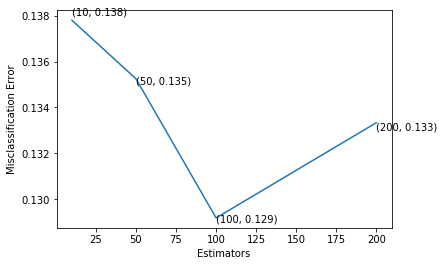

the misclassification error for each estimator value is :  [0.138 0.135 0.129 0.133]


In [30]:
# Calculating the miss-classification error
MissClErrBow = [1-x for x in accuracy_scores]

# determining the best depth
optimal_estimators = estimators[MissClErrBow.index(min(MissClErrBow))]
print('\nThe optimal depth is %d.' % optimal_estimators)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(estimators,MissClErrBow)

for xy in zip(estimators, np.round(MissClErrBow,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each estimator value is : ", np.round(MissClErrBow,3))

# We can see that for estimator value of 100 we get minimum missclassification error.

# Creating a Random Forest model with BoW text representation with estimator value of 100.

In [31]:
rf_bow_final = RandomForestClassifier(n_estimators=100)
rf_bow_final.fit(X_tr, y_tr)
pred_bow_final = rf_bow_final.predict(X_test)

# evaluate CV accuracy
acc_bow = accuracy_score(y_test, pred_bow_final, normalize=True) * float(100)

print('\nThe accuracy of the Random Forest Classifier for depth = %d is %f%%' % (optimal_estimators, acc_bow))



The accuracy of the Random Forest Classifier for depth = 100 is 86.626479%


# Using the TF-IDF text representation to create our Naive Bayes models

In [32]:
# In this stage we have initialized the tf-idf vectorizer and applied it to the text data which has been stored in the final_tf_idf vriable

tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

In [34]:
# Assigning the final_tf_idf data to 'X1' variable

X1 = final_tf_idf

In [35]:
# Assinging the score to 'y1' variable

y1 = np.array(sorted_final['Score'])

In [ ]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3) # Splitting train test with 70:30 ratio

In [37]:
# Splitting the train data into train and cross validation sets

X_tr1, X_CV1, y_tr1, y_CV1 = train_test_split(X_train1, y_train1, test_size=0.3) # Splitting train cross-val with 70:30 ratio

In [1]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We have taken the following values for 'alpha'
estimators = [10,50,100,200]
accuracy_scores_tfidf = []

for i in estimators:
    rf_tfidf = RandomForestClassifier(n_estimators=i)
    rf_tfidf.fit(X_tr1, y_tr1)
    pred_tfidf = rf.predict(X_CV1)
    
    # evaluate CV accuracy
    acc_tfidf = accuracy_score(y_CV1, pred_tfidf, normalize=True) # * float(100)
    accuracy_scores_tfidf.append(acc_tfidf)


"from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score\n\n# We have taken the following values for 'alpha'\nestimators = [10,50,100,200]\naccuracy_scores_tfidf = []\n\nfor i in estimators:\n    rf_tfidf = RandomForestClassifier(n_estimators=i)\n    rf_tfidf.fit(X_tr1, y_tr1)\n    pred_tfidf = rf.predict(X_CV1)\n    \n    # evaluate CV accuracy\n    acc_tfidf = accuracy_score(y_CV1, pred_tfidf, normalize=True) # * float(100)\n    accuracy_scores_tfidf.append(acc_tfidf)"

In [ ]:
# Calculating the miss-classification error
MissClErrTfidf = [1-x for x in accuracy_scores_tfidf]

# determining the best depth
optimal_estimators = depth[MissClErrTfidf.index(min(MissClErrTfidf))]
print('\nThe optimal depth is %d.' % optimal_estimators)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(estimators,MissClErrTfidf)

for xy in zip(depth, np.round(MissClErrTfidf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each estimator value is : ", np.round(MissClErrTfidf,3))

# Using the W2Vec representation of the text data to apply the Random Forest Classifier

In [24]:
# Importing the required models for the project

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\kulkarni\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [25]:
import gensim
i=0
list_of_sent=[]
for sent in sorted_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [26]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=3)

In [27]:
words = list(w2v_model.wv.vocab)
print(len(words))

7874


# Creating an Avg W2Vec representation of each review

In [28]:
# Computing the Avg W2Vec representation of each review and storing it in 'sent_vectors' list

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

15024
50


In [29]:
# Storing the list in a variable 'X2'

X2 = sent_vectors

In [30]:
# Storing the review score in a 'y2' variable

y2 = sorted_final['Score']

In [32]:
# Splitting the data into train test sets

from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3) # Splitting train test with 70:30 ratio

In [33]:
# Splitting the train data into train and cross validation sets

X_tr2, X_CV2, y_tr2, y_CV2 = train_test_split(X_train2, y_train2, test_size=0.3) # Splitting train cross-val with 70:30 ratio

In [34]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We have taken the following values for 'alpha'
estimators = [10,50,100,200]
accuracy_scores_avgw2vec = []

for i in estimators:
    rf_avgw2vec = RandomForestClassifier(n_estimators=i)
    rf_avgw2vec.fit(X_tr2, y_tr2)
    pred_avgw2vec = rf_avgw2vec.predict(X_CV2)
    
    # evaluate CV accuracy
    acc_avgw2vec = accuracy_score(y_CV2, pred_avgw2vec, normalize=True) # * float(100)
    accuracy_scores_avgw2vec.append(acc_avgw2vec)
    


The optimal depth is 100.


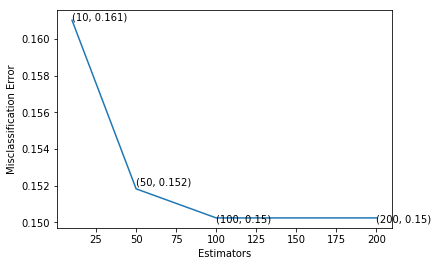

the misclassification error for each estimator value is :  [0.161 0.152 0.15  0.15 ]


In [37]:
# Calculating the miss-classification error
MissClErrAvgW2Vec = [1-x for x in accuracy_scores_avgw2vec]

# determining the best depth
optimal_estimators = estimators[MissClErrAvgW2Vec.index(min(MissClErrAvgW2Vec))]
print('\nThe optimal depth is %d.' % optimal_estimators)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(estimators,MissClErrAvgW2Vec)

for xy in zip(estimators, np.round(MissClErrAvgW2Vec,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each estimator value is : ", np.round(MissClErrAvgW2Vec,3))

# We can see that for the estimator value of 100 we get the minimum missclassification error.

# Creating a Random Forest model with avgW2Vec text representation with an estimator value of 100

In [38]:
rf_avgw2vec = RandomForestClassifier(n_estimators=100)
rf_avgw2vec.fit(X_tr2, y_tr2)
pred_avgw2vec = rf_avgw2vec.predict(X_test2)

# evaluate CV accuracy
acc_avgw2vec = accuracy_score(y_test2, pred_avgw2vec, normalize=True) * float(100)

print('\nThe accuracy of the Random Forest Classifier for depth = %d is %f%%' % (optimal_estimators, acc_avgw2vec))



The accuracy of the Random Forest Classifier for depth = 100 is 84.405501%


# Creating a Tf-Idf weighted W2Vec representation of each review

In [40]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sorted_final['Cleaned_Text'].values).todense()

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\kulkarni\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [41]:
# Checking for any 'NaN' values in the data

np.isnan(tfidf_sent_vectors).any()

# We can see that there are na values in the data

True

In [42]:
# We will replace all the 'Nan' values w/ mean of the respective columns


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_tfidf = imp.fit_transform(tfidf_sent_vectors) # Assigning the imputed matrix w/o Nan values to data variable

In [43]:
# Checking if our imputation has succeded

np.isnan(data_tfidf).any()

# We can see that there are no na values any more.

False

In [44]:
# Assigning the 'data_tfidf' matrix to 'X3' variable

X3 = data_tfidf

In [45]:
# Assigning the scores to the 'y3' variable

y3 = sorted_final['Score']

In [46]:
# Splitting the data into train test sets

#from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3) # Splitting train test with 70:30 ratio

In [47]:
# Splitting the train data into train and cross validation sets

X_tr3, X_CV3, y_tr3, y_CV3 = train_test_split(X_train3, y_train3, test_size=0.3) # Splitting train cross-val with 70:30 ratio

In [48]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# We have taken the following values for 'alpha'
estimators = [10,50,100,200]
accuracy_scores_tfidfw2vec = []

for i in estimators:
    rf_tfidfw2vec = RandomForestClassifier(n_estimators=i)
    rf_tfidfw2vec.fit(X_tr3, y_tr3)
    pred_tfidfw2vec = rf_tfidfw2vec.predict(X_CV3)
    
    # evaluate CV accuracy
    acc_tfidfw2vec = accuracy_score(y_CV3, pred_tfidfw2vec, normalize=True) # * float(100)
    accuracy_scores_tfidfw2vec.append(acc_tfidfw2vec)


The optimal depth is 100.


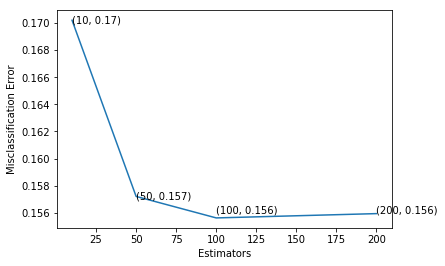

the misclassification error for each estimator value is :  [0.17  0.157 0.156 0.156]


In [50]:
# Calculating the miss-classification error
MissClErrtfidfW2Vec = [1-x for x in accuracy_scores_tfidfw2vec]

# determining the best depth
optimal_estimators = estimators[MissClErrtfidfW2Vec.index(min(MissClErrtfidfW2Vec))]
print('\nThe optimal depth is %d.' % optimal_estimators)

# importing matplotlib
import matplotlib.pyplot as plt

plt.plot(estimators,MissClErrtfidfW2Vec)

for xy in zip(estimators, np.round(MissClErrtfidfW2Vec,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each estimator value is : ", np.round(MissClErrtfidfW2Vec,3))

# We can see that for the estimator value of 100 we get the minimum missclassification error.

# Creating a Random Forest model with avgW2Vec text representation with an estimator value of 100

In [51]:
rf_tfidfw2vec = RandomForestClassifier(n_estimators=100)
rf_tfidfw2vec.fit(X_tr3, y_tr3)
pred_tfidfw2vec = rf_tfidfw2vec.predict(X_test3)

# evaluate CV accuracy
acc_tfidf = accuracy_score(y_test3, pred_tfidfw2vec, normalize=True) * float(100)

print('\nThe accuracy of the Random Forest Classifier for depth = %d is %f%%' % (optimal_estimators, acc_tfidf))


The accuracy of the Random Forest Classifier for depth = 100 is 84.738243%


# In this problem we have applied the Random Forest Classifier to the data. We have only considered data in the form of BoW, AvgW2Vec and TF-IDF W2Vec.

# We have not considered the TF-IDF representation because the time-complexity was very large as observed while running the operations on the data.

# Following results have been observed for the data using the available text representations.

# From the results we can observe that even though the time complexity for BoW representations is high, the accuracy we get on the test data for BoW is also the highest, which is 86.62%. If we had used Tf-IDF as well we might have got a more high accuracy.